In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
from openpyxl import load_workbook

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


from parser.inflation import download_inflation, get_inflation_df
from parser.gdp import get_dfg_dataframe
from data_transform.transform_df import transform_df_to_format

In [81]:
start_date = datetime.datetime.strptime("01.01.2022", "%d.%m.%Y")
end_date = datetime.datetime.strptime("01.02.2024", "%d.%m.%Y")
download_inflation(start_date, end_date)
df_inflation = transform_df_to_format(get_inflation_df(start_date, end_date))
df_inflation 

C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,"Ключевая ставка, % годовых","Инфляция, % г/г",month_n,year,Отчетный период
0,8.5,8.73,1,2022,Январь 2022 г.
31,20.0,9.15,2,2022,Февраль 2022 г.
59,20.0,16.69,3,2022,Март 2022 г.
90,17.0,17.83,4,2022,Апрель 2022 г.
120,11.0,17.10,5,2022,Май 2022 г.
151,9.5,15.90,6,2022,Июнь 2022 г.
181,8.0,15.10,7,2022,Июль 2022 г.
212,8.0,14.30,8,2022,Август 2022 г.
243,7.5,13.68,9,2022,Сентябрь 2022 г.
273,7.5,12.63,10,2022,Октябрь 2022 г.


Создание датафрейма из таблицы с объемом кредитов

In [82]:
df =  pd.read_excel('../stat_bulletin_lending_24-01_45.xlsx', sheet_name = 'Таблица 1', skiprows = 2)
df.to_csv("Test.csv")
replace_text = ' '
for i in range(1, len(df.columns)): 
    if df.columns[i] == 'Unnamed: ' + str(i):
        if count==0:
            replace_text = df.columns.values[i-1] 
            df.columns.values[i-1] = df.columns.values[i-1] + '<>' + df.iloc[0][i-1]
        df.columns.values[i] = replace_text + '<>' + df.iloc[0][i]
        count += 1
    else:
        count = 0

df = df.drop(0, axis = 0)
df

C:\Users\Дарья\AppData\Local\Temp\ipykernel_16608\3790058400.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.columns.values[i-1] = df.columns.values[i-1] + '<>' + df.iloc[0][i-1]
C:\Users\Дарья\AppData\Local\Temp\ipykernel_16608\3790058400.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.columns.values[i] = replace_text + '<>' + df.iloc[0][i]


,Отчетный период,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в рублях","Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в иностранной валюте","Количество кредитов, предоставленных субъектам МСП, в рублях и иностранной валюте, ед.","Средний размер кредита субъектов МСП, млн руб.","Количество субъектов МСП, получивших кредит в отчетном месяце, ед."
1,Январь 2022 г.,800529,798524,2006,181204.0,4.4,163871.0
2,Февраль 2022 г.,964639,960168,4471,201384.0,4.8,179660.0
3,Март 2022 г.,816031,815581,450,171437.0,4.8,157676.0
4,Апрель 2022 г.,808912,784373,24539,166472.0,4.9,151661.0
5,Май 2022 г.,676283,663850,12433,167614.0,4.0,152422.0
6,Июнь 2022 г.,944500,944318,182,182677.0,5.2,163929.0
7,Июль 2022 г.,926997,836025,90972,178479.0,5.2,159839.0
8,Август 2022 г.,959111,921727,37384,186475.0,5.1,166101.0
9,Сентябрь 2022 г.,1087392,1029413,57979,191022.0,5.7,169842.0
10,Октябрь 2022 г.,1105843,1105443,400,186379.0,5.9,166647.0


In [83]:
df['Отчетный период'] = df['Отчетный период'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 1 to 25
Data columns (total 7 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Отчетный период                                                                            25 non-null     object 
 1   Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего                             25 non-null     object 
 2   Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в рублях              25 non-null     object 
 3   Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в иностранной валюте  25 non-null     object 
 4   Количество кредитов, предоставленных субъектам МСП, в рублях и иностранной валюте, ед.     25 non-null     float64
 5   Средний размер кредита субъектов МСП, млн руб.       

In [84]:
df = df[['Отчетный период', 'Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']]
df = df.reset_index()
df = df.drop('index', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column                                                          Non-Null Count  Dtype 
---  ------                                                          --------------  ----- 
 0   Отчетный период                                                 25 non-null     object
 1   Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего  25 non-null     object
dtypes: object(2)
memory usage: 532.0+ bytes


Получим датафрейм с ВВП

In [91]:
df_gdp = transform_df_to_format(get_dfg_dataframe())
df_gdp 

,gdp,month_n,year,Отчетный период
0,9627.729494,1,1995,Январь 1995 г.
31,9627.729494,2,1995,Февраль 1995 г.
59,9627.729494,3,1995,Март 1995 г.
90,9627.729494,4,1995,Апрель 1995 г.
120,9627.729494,5,1995,Май 1995 г.
...,...,...,...,...
6056,391486.228965,8,2011,Август 2011 г.
6087,391486.228965,9,2011,Сентябрь 2011 г.
6117,391486.228965,10,2011,Октябрь 2011 г.
6148,391486.228965,11,2011,Ноябрь 2011 г.


In [86]:
df_total = pd.merge(df, df_inflation, on='Отчетный период', how='inner')
df_total

,Отчетный период,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Ключевая ставка, % годовых","Инфляция, % г/г",month_n,year
0,Январь 2022 г.,800529,8.5,8.73,1,2022
1,Февраль 2022 г.,964639,20.0,9.15,2,2022
2,Март 2022 г.,816031,20.0,16.69,3,2022
3,Апрель 2022 г.,808912,17.0,17.83,4,2022
4,Май 2022 г.,676283,11.0,17.10,5,2022
5,Июнь 2022 г.,944500,9.5,15.90,6,2022
6,Июль 2022 г.,926997,8.0,15.10,7,2022
7,Август 2022 г.,959111,8.0,14.30,8,2022
8,Сентябрь 2022 г.,1087392,7.5,13.68,9,2022
9,Октябрь 2022 г.,1105843,7.5,12.63,10,2022


In [87]:
df_total = df_total.drop('Отчетный период', axis = 1)

In [88]:
df_total.corr()

,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Ключевая ставка, % годовых","Инфляция, % г/г",month_n,year
"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего",1.000000,0.114866,-0.619060,0.652899,0.439009
"Ключевая ставка, % годовых",0.114866,1.000000,0.142106,-0.093470,0.065087
"Инфляция, % г/г",-0.619060,0.142106,1.000000,-0.002229,-0.734708
month_n,0.652899,-0.093470,-0.002229,1.000000,-0.156206
year,0.439009,0.065087,-0.734708,-0.156206,1.000000


In [89]:
#df_total = df_total[['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего', 'Инфляция, % г/г', 'month_n']]
#df_total.head()

In [90]:
# подготовка данных
trg = df_total[['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']]
trn = df_total.drop('Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего', axis=1)

# разделение данных
Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.2, random_state = 42)

# Создание и обучение модели
regressor = CatBoostRegressor(iterations=200, depth=4, learning_rate=0.01)
regressor.fit(Xtrn, Ytrn, verbose=False)

# Предсказание и оценка
predictions = regressor.predict(Xtest)
print(predictions)

[1023089.50314054 1208056.63763118  981794.87229641 1309921.0979974
 1030901.280195  ]


Метрики точности:

* R-squared (R²): Коэффициент детерминации, показывает долю дисперсии целевой переменной, объясненную моделью (от 0 до 1, чем ближе к 1, тем лучше).
* Mean Absolute Error (MAE):  Средняя абсолютная ошибка, показывает среднюю величину ошибки предсказания.
* Mean Squared Error (MSE):  Средняя квадратичная ошибка, чувствительна к большим ошибкам.
* Root Mean Squared Error (RMSE):  Корень из средней квадратичной ошибки, интерпретируется в тех же единицах, что и целевая переменная.

In [58]:
r2 = r2_score(Ytest, predictions)
mae = mean_absolute_error(Ytest, predictions)
mse = mean_squared_error(Ytest, predictions)
rmse = mean_squared_error(Ytest, predictions, squared=False)  # squared=False для RMSE

print(f"R-squared: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

R-squared: 0.28
MAE: 223691.73
MSE: 87811761044.12
RMSE: 296330.49


C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R-squared меньше 0,5 - у модели плохая точность

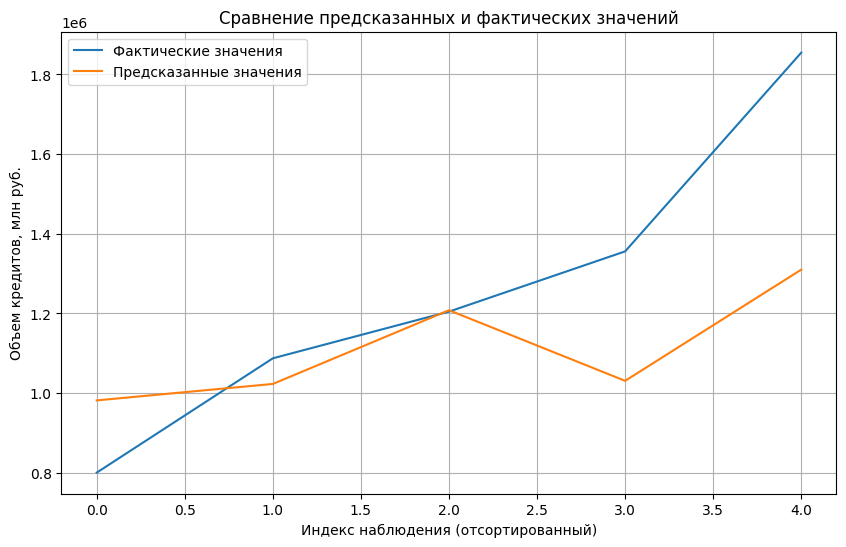

In [59]:
# Для красивой визуализации отсортируем данные по возрастанию фактических значений
sorted_indices = Ytest['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'].argsort()
Ytest_sorted = Ytest.iloc[sorted_indices]
predictions_sorted = predictions[sorted_indices]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(Ytest_sorted.values, label='Фактические значения')
plt.plot(predictions_sorted, label='Предсказанные значения')
plt.xlabel('Индекс наблюдения (отсортированный)')
plt.ylabel('Объем кредитов, млн руб.')
plt.title('Сравнение предсказанных и фактических значений')
plt.legend()
plt.grid(True)
plt.show()

Линейная 

In [60]:
models = [LinearRegression(), # метод наименьших квадратов
	          RandomForestRegressor(n_estimators=100, max_features ='sqrt'), # случайный лес
	          KNeighborsRegressor(n_neighbors=6), # метод ближайших соседей
	          SVR(kernel='linear'), # метод опорных векторов с линейным ядром
          CatBoostRegressor(verbose=False),
	          ]

In [61]:
# подготовка данных
trg_lin = df_total[['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']]
trn_lin = df_total.drop('Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего', axis=1)

# разделение данных
Xtrn_lin, Xtest_lin, Ytrn_lin, Ytest_lin = train_test_split(trn_lin, trg_lin, test_size=0.2, random_state = 42)

# Создание и обучение модели
model = models[0]
model.fit(Xtrn_lin, Ytrn_lin)

# Предсказание и оценка
predictions1 = model.predict(Xtest_lin)
print(predictions1)

[[1028149.80547737]
 [1303247.28837965]
 [ 819073.06610212]
 [1618130.01744352]
 [1256933.50256476]]


In [63]:
r2 = r2_score(Ytest_lin, predictions1)
mae = mean_absolute_error(Ytest_lin, predictions1)
mse = mean_squared_error(Ytest_lin, predictions1)
rmse = mean_squared_error(Ytest_lin, predictions1, squared=False)  # squared=False для RMSE

print(f"R-squared: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

R-squared: 0.87
MAE: 102325.21
MSE: 15842969261.89
RMSE: 125868.86


C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


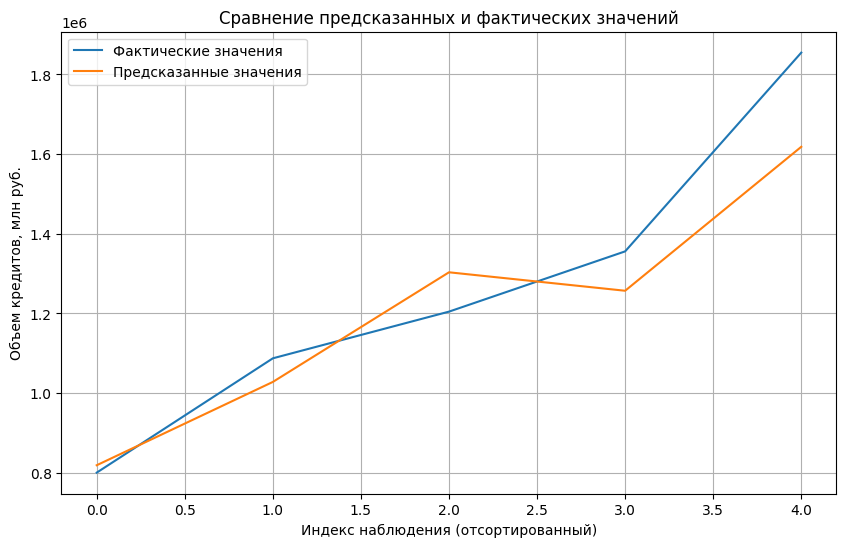

In [64]:
# Для красивой визуализации отсортируем данные по возрастанию фактических значений
sorted_indices1 = Ytest_lin['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'].argsort()
Ytest_sorted1 = Ytest_lin.iloc[sorted_indices1]
predictions_sorted1 = predictions1[sorted_indices1]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(Ytest_sorted1.values, label='Фактические значения')
plt.plot(predictions_sorted1, label='Предсказанные значения')
plt.xlabel('Индекс наблюдения (отсортированный)')
plt.ylabel('Объем кредитов, млн руб.')
plt.title('Сравнение предсказанных и фактических значений')
plt.legend()
plt.grid(True)
plt.show()

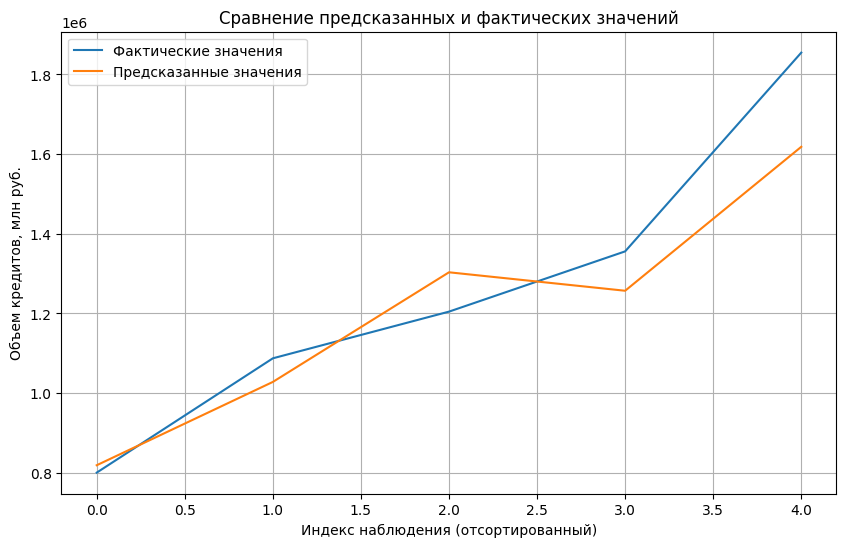

In [65]:
# Для красивой визуализации отсортируем данные по возрастанию фактических значений
sorted_indices1 = Ytest_lin['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'].argsort()
Ytest_sorted1 = Ytest_lin.iloc[sorted_indices1]
predictions_sorted1 = predictions1[sorted_indices1]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(Ytest_sorted1.values, label='Фактические значения')
plt.plot(predictions_sorted1, label='Предсказанные значения')
plt.xlabel('Индекс наблюдения (отсортированный)')
plt.ylabel('Объем кредитов, млн руб.')
plt.title('Сравнение предсказанных и фактических значений')
plt.legend()
plt.grid(True)
plt.show()

Выполним предсказание на 2025 год

In [17]:
predictions_2025 = regressor.predict(data_for_predict)
print(predictions)

[1023761.66029432 1017324.27538279 1108101.64955737 1375035.65511825
 1028902.98456526]


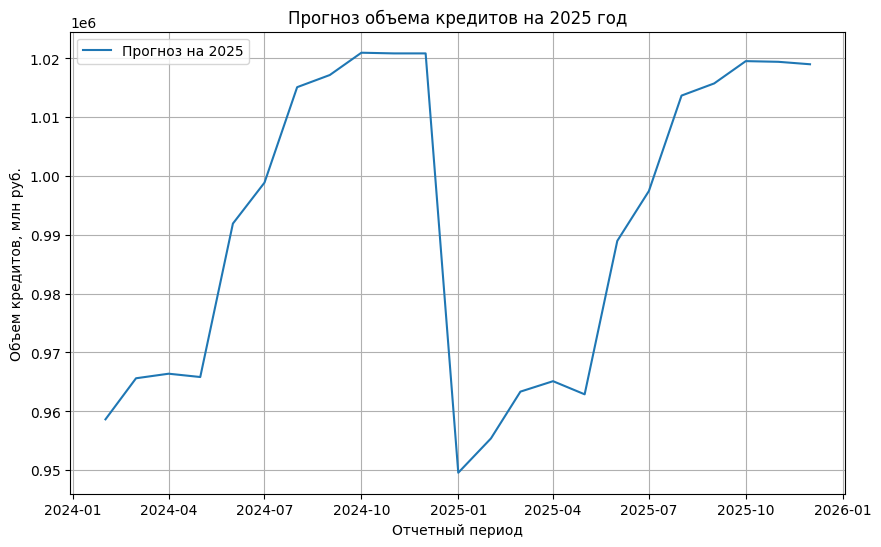

In [18]:
predictions_2025 = regressor.predict(data_for_predict)

plt.figure(figsize=(10, 6))
plt.plot(data_for_predict_in_memory['Отчетный период'], predictions_2025, label='Прогноз на 2025')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, млн руб.')
plt.title('Прогноз объема кредитов на 2025 год')
plt.legend()
plt.grid(True)
plt.show() 